In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import neuromaps
from neuromaps import datasets, transforms, images, resampling, nulls, stats
from scipy.stats import pearsonr, spearmanr, zscore, rankdata
from statsmodels.stats.multitest import multipletests
import math

from itertools import combinations
from neuromaps.datasets import fetch_atlas
from neuromaps.images import load_data
from neuromaps.datasets import fetch_annotation
from neuromaps import plotting
from neuromaps import datasets, images, nulls, resampling
from neuromaps.stats import compare_images
from statsmodels.stats.multitest import multipletests

In [2]:
print("neuromaps version:", neuromaps.__version__)

neuromaps version: 0.0.5+41.gf0ed67c


In [3]:
!wb_command -version

Connectome Workbench
Type: Command Line Application
Version: 2.0.1
Qt Compiled Version: 6.2.3
Qt Runtime Version: 6.2.3
Commit: 150de12f4f4b94b39bec6d9133ad2e7019d2d3ef
Commit Date: 2024-10-15 17:38:41 -0500
Compiler: c++ (/Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin)
Compiler Version: 13.0.0.13000029
Compiled Debug: NO
Operating System: Apple OSX
Compiled with OpenMP: YES


### Data Pre-Processing 

In [4]:
## Preprocessing brain data

brain_maps = [
    {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'},
    {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'},
    {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'},
    {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'},
    {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'},
    {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'},
    {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'},
    {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'}
]

single_sphere_counter = 0
for map in brain_maps:
    brain_map = datasets.fetch_annotation(**map)
    if len(brain_map) != 2:
        single_sphere_counter += 1
        print(map)
print(single_sphere_counter)

readable_map_names = {
    'genepc1': 'PC1 Gene Expression',
    'myelinmap': 'T1w/T2w Ratio',
    'thickness': 'Cortical Thickness',
    'fcgradient01': 'Functional Gradient',
    'intersubjvar': 'Intersubject Variability',
    'cmrglc': 'Glucose Metabolism',
    'scalingnih': 'Allometric Scaling (NIH)',
    'way100635':' 5-HT1A Receptor'
}


[References] Please cite the following papers if you are using this data:

  For {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'}:
  [primary]:
    Markus Savli, Andreas Bauer, Markus Mitterhauser, Yu-Shin Ding, Andreas Hahn, Tina Kroll, Alexander Neumeister, Daniela Haeusler, Johanna Ungersboeck, Shannan Henry, and others. Normative database of the serotonergic system in healthy subjects using multi-tracer pet. Neuroimage, 63(1):447–459, 2012.
  [secondary]:
    
{'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'}

[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a princ

In [ ]:
def is_volumetric(map_dict):
    """Check if a map is volumetric (MNI space)"""
    return map_dict.get('space') in ['MNI152', 'MNI305']

## Load and transform the dara
def load_and_prepare_map(map_dict, readable_map_names=None, target_space='fsLR', target_den='32k'):
    """
    Load a brain map and prepare it for analysis
    - Volumetric maps: transform to surface
    - Surface maps: resample if needed, use both hemispheres
    - return (transformed data array, space, density)
    """
    # Determine display name for logging
    desc = map_dict['desc']
    if readable_map_names and desc in readable_map_names:
        display_name = readable_map_names[desc]
    else:
        display_name = desc
    
    # Fetch the map
    brain_map = datasets.fetch_annotation(**map_dict)
    
    # Check if volumetric
    if is_volumetric(map_dict):
        print(f"Volumetric map detected, transforming to {target_space} surface...")
        
        # Transform volumetric to surface (both hemispheres)
        try:
            surface_map = transforms.mni152_to_fslr(brain_map, fslr_density=target_den)
            # surface_map will be a tuple of (left_hemi, right_hemi)
            lh_data = images.load_data(surface_map[0])
            rh_data = images.load_data(surface_map[1])
            full_data = np.hstack([lh_data, rh_data])
            return full_data, target_space, target_den
            
        except Exception as e:
            print(f"    Warning: Could not transform volumetric map: {e}")
 
    # Surface map processing
    else:
        src_space = map_dict.get('space')
        src_den = map_dict.get('den')
        template = {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}
        template_map = datasets.fetch_annotation(**template)
        # Load both hemispheres
        if len(brain_map) == 2:
            lh_map, rh_map = brain_map
        else:
            raise ValueError(f"Expected 2 hemispheres for surface map, got {len(brain_map)}")
        
        if src_den != target_den or src_space != target_space:
            print(f"Resampling from {src_space}-{src_den} to {target_space}-{target_den}...")            
            # Resample both hemispheres
            lh_resampled, _ = resampling.resample_images(
                lh_map, template_map[0],
                src_space=src_space, trg_space=target_space,
                hemi='L', resampling='transform_to_trg'
            )
            rh_resampled, _ = resampling.resample_images(
                rh_map, template_map[1],
                src_space=src_space, trg_space=target_space,
                hemi='R', resampling='transform_to_trg'
            )
            
            lh_data = images.load_data(lh_resampled)
            rh_data = images.load_data(rh_resampled)
        else:
            lh_data = images.load_data(lh_map)
            rh_data = images.load_data(rh_map)
        
        full_data = np.hstack([lh_data, rh_data])
        return full_data, src_space if src_den == target_den else target_space, \
               src_den if src_den == target_den else target_den

In [28]:
def compute_spin_spearman_analysis(
                                    brain_maps,
                                    n_perm=1000,
                                    target_space='fsLR',
                                    target_den='32k',
                                    seed=1234,
                                    readable_map_names=None):
    """
    Spearman-only brain map analysis with Alexander-Bloch spin correction.

    Returns:
        cov_empirical      (Spearman-based covariance matrix)
        cov_pvalues        (Spin-based p-values)
        corr_empirical     (Spearman correlation matrix)
        df_corr
        df_pvals
        df_significant
        map_names
        prepared_maps
        nulls_list
    """
    prepared_maps = []
    map_names = []

    for brain_map in brain_maps:
        prep_map, final_space, final_den = load_and_prepare_map(
            brain_map, readable_map_names
        )
        prepared_maps.append(prep_map)
        map_names.append(f"{brain_map['source']}_{brain_map['desc']}")

    n_maps = len(prepared_maps)

    nulls_list = []
    for prep_map in prepared_maps:
        rotated = nulls.alexander_bloch(
            prep_map,
            atlas=target_space,
            density=target_den,
            n_perm=n_perm,
            seed=seed
        )
        nulls_list.append(rotated)


    data_stack = np.column_stack(prepared_maps)
    global_mask = np.all(~np.isnan(data_stack), axis=1)

    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]


    ranked = np.apply_along_axis(rankdata, 0, clean_data)
    z_ranked = zscore(ranked, axis=0)

    corr_empirical = (z_ranked.T @ z_ranked) / n_vertices_clean

    p_counts = np.zeros((n_maps, n_maps))
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]

    for k in range(n_perm):
        null_data_k = np.zeros_like(z_ranked)

        for m in range(n_maps):
            spin_k = clean_nulls_list[m][:, k]
            spin_ranked = rankdata(spin_k)
            null_data_k[:, m] = zscore(spin_ranked)

        null_corr_k = np.corrcoef(null_data_k.T)

        p_counts += (np.abs(null_corr_k) >= np.abs(corr_empirical))

    cov_pvalues = (p_counts + 1) / (n_perm + 1)

    stds = np.std(clean_data, axis=0)
    cov_empirical = corr_empirical * np.outer(stds, stds)


    display_names = map_names
    if readable_map_names is not None:
        display_names = [
            readable_map_names.get(name, name) for name in map_names
        ]

    df_corr = pd.DataFrame(corr_empirical, index=display_names, columns=display_names).round(3)
    df_pvals = pd.DataFrame(cov_pvalues, index=display_names, columns=display_names).round(3)

    df_significant = df_corr.copy()
    df_significant[df_pvals > 0.05] = 0

    return (
        cov_empirical,
        cov_pvalues,
        corr_empirical,
        df_corr,
        df_pvals,
        df_significant,
        map_names,
        prepared_maps,
        nulls_list
    )


## Function to plot heatmaps
def plot_correlation_heatmaps(df_corr, df_significant, method=None):
    """
    Plots two side-by-side heatmaps: 
    1. The Full Correlation Matrix
    2. The Significant-Only Matrix (Non-significant cells masked)
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    sns.heatmap(
        df_corr, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        ax=axes[0],
        cbar_kws={'label': method}
    )
    axes[0].set_title("Full Correlation Matrix", fontsize=16)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # plot matrix masked
    mask = (df_significant == 0)
    
    sns.heatmap(
        df_significant, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        mask=mask, # hide non significant cells
        ax=axes[1],
        cbar_kws={'label': method}
    )
    axes[1].set_title("Significant Correlations Only (p < 0.05)", fontsize=16)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()


[References] Please cite the following papers if you are using this data:

  For {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'}:
  [primary]:
    Markus Savli, Andreas Bauer, Markus Mitterhauser, Yu-Shin Ding, Andreas Hahn, Tina Kroll, Alexander Neumeister, Daniela Haeusler, Johanna Ungersboeck, Shannan Henry, and others. Normative database of the serotonergic system in healthy subjects using multi-tracer pet. Neuroimage, 63(1):447–459, 2012.
  [secondary]:
    
Volumetric map detected, transforming to fsLR surface...

[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macr

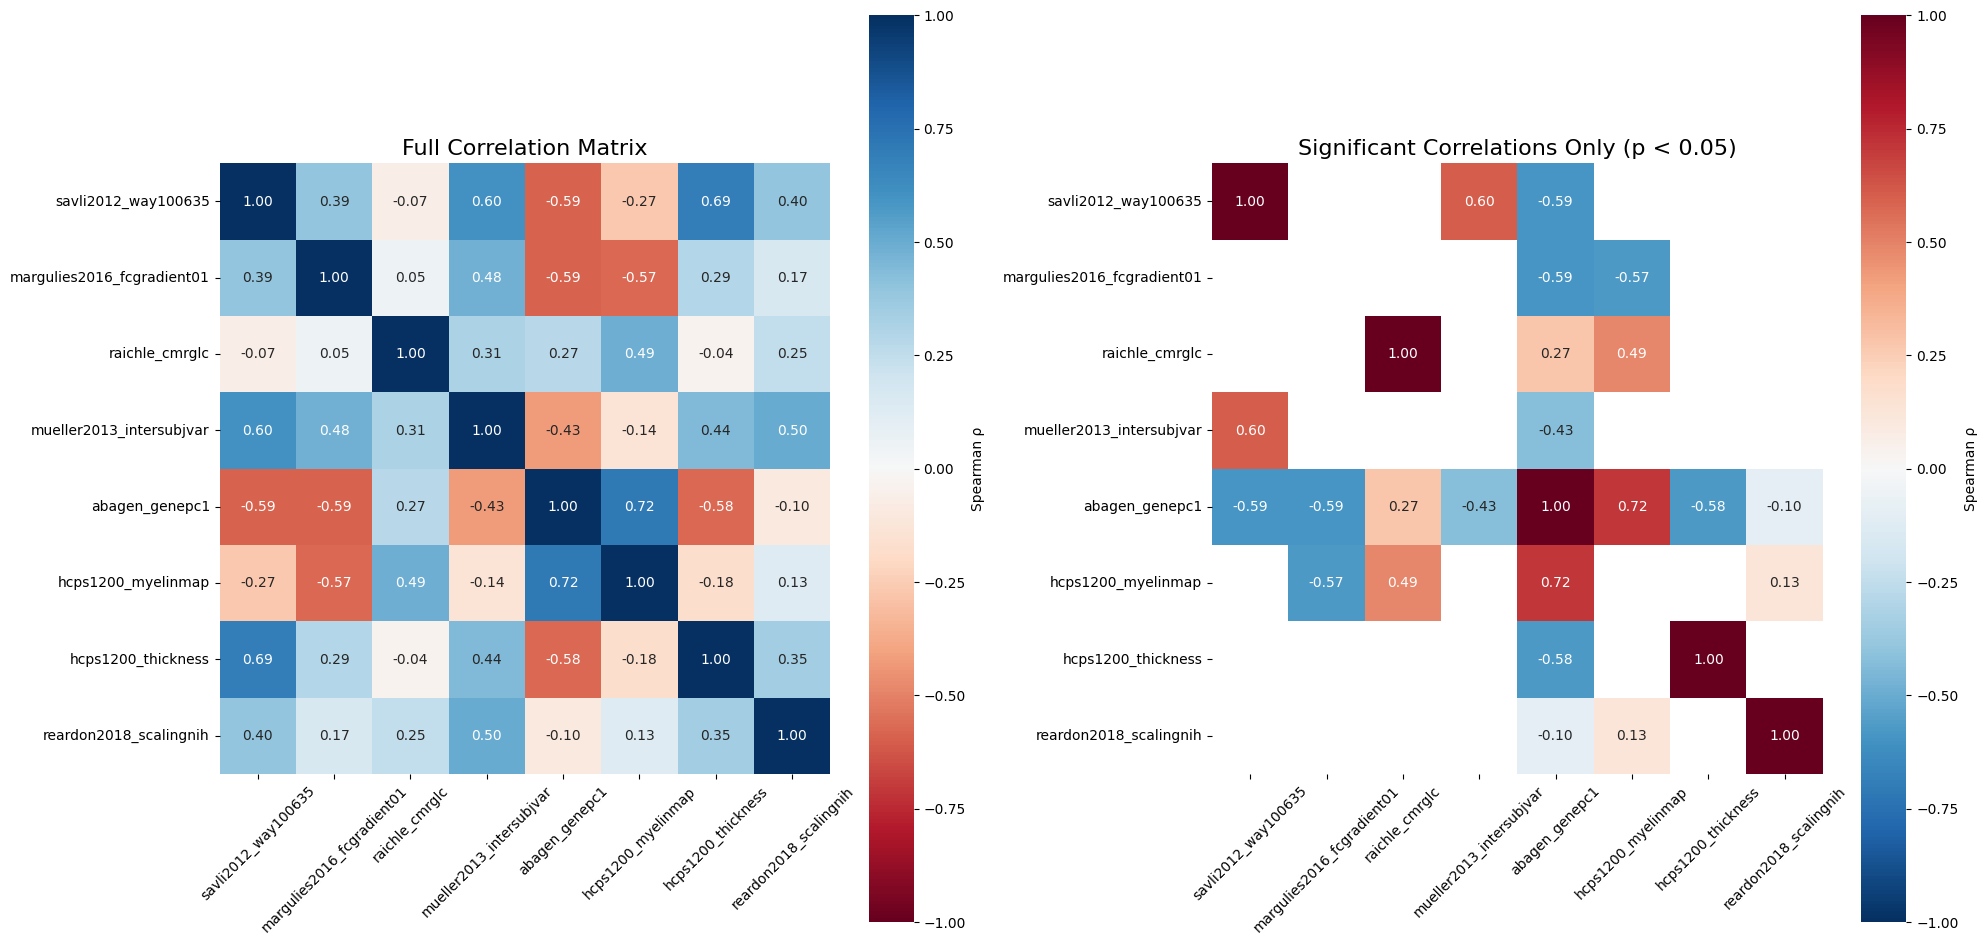

In [29]:
cov_emp, cov_pvals, corr_emp, df_corr_spearman, df_pvals_spearman, df_significant_spearman, map_names, prepared_maps, nulls_list = compute_spin_spearman_analysis(   
    brain_maps,
    n_perm=1000,
    target_space='fsLR',
    target_den='32k',
    seed=1234,
    readable_map_names=readable_map_names)

plot_correlation_heatmaps(df_corr_spearman, df_significant_spearman, method='Spearman ρ')

### EDA Plotting

In [30]:
# Plotting Spearman Correlation heatmap

## Spearman Rank
def compute_correlation_matrix_spearman(prepared_maps, map_names, nulls_list, n_perm=1000, readable_map_names=None):
    """
    correlation matrix using SPEARMAN RANK CORRELATION.
    Use this if your data has non-linear monotonic relationships.
    
    Parameters:
    - prepared_maps: List of numpy arrays (N_vertices,) for each map.
    - map_names: List of strings naming each map.
    - nulls_list: List of null arrays (N_vertices, n_perm) for each map.
    - n_perm: Number of permutations used (default 1000).
    - readable_map_names: Dictionary mapping map keys (desc) to readable strings.
    """

    data_stack = np.column_stack(prepared_maps)

    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]
    
    # Rank the data converts raw values to ranks (1st, 2nd, 3rd...)
    clean_data_ranked = np.apply_along_axis(rankdata, 0, clean_data)
    clean_data_z = zscore(clean_data_ranked, axis=0)

    real_corr = (clean_data_z.T @ clean_data_z) / n_vertices_clean
    
    p_counts = np.zeros((len(prepared_maps), len(prepared_maps)))
    
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    
    for k in range(n_perm):        
        null_data_k = np.zeros_like(clean_data_z)
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            spin_k_ranked = rankdata(spin_k, nan_policy='omit')
            null_data_k[:, m] = zscore(spin_k_ranked, nan_policy='omit')
        null_corr_k = np.corrcoef(null_data_k.T)
        # Check: Is random correlation stronger than real correlation?
        is_stronger = np.abs(null_corr_k) >= np.abs(real_corr)
        p_counts += is_stronger.astype(int)

    p_values = (p_counts + 1) / (n_perm + 1)
    
    display_names = map_names
    if readable_map_names is not None:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            if not found_match:
                display_names.append(name)
    
    df_corr = pd.DataFrame(real_corr, index=display_names, columns=display_names).round(3)
    df_pvals = pd.DataFrame(p_values, index=display_names, columns=display_names).round(3)
    
    # Mask non-significant values (rho > 0.05)
    df_significant = df_corr.copy()
    df_significant[df_pvals > 0.05] = 0
    
    return df_corr, df_pvals, df_significant

## Function to plot heatmaps
def plot_correlation_heatmaps(df_corr, df_significant, method=None):
    """
    Plots two side-by-side heatmaps: 
    1. The Full Correlation Matrix
    2. The Significant-Only Matrix (Non-significant cells masked)
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    sns.heatmap(
        df_corr, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        ax=axes[0],
        cbar_kws={'label': method}
    )
    axes[0].set_title("Full Correlation Matrix", fontsize=16)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # plot matrix masked
    mask = (df_significant == 0)
    
    sns.heatmap(
        df_significant, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        mask=mask, # hide non significant cells
        ax=axes[1],
        cbar_kws={'label': method}
    )
    axes[1].set_title("Significant Correlations Only (p < 0.05)", fontsize=16)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

In [31]:
## Funciton to plot EDA pairwise scatter plots 

def plot_pairwise_scatterplots(prepared_maps, map_names, readable_map_names=None):
    # data prep
    # 32k rows 8 columns
    data_stack = np.column_stack(prepared_maps)
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1) # get rid of NaNs
    clean_data = data_stack[global_mask]
    
    n_maps = len(prepared_maps)
    
    # making sure brain maps names exist and are readable
    # uses readable names instead of desc name
    display_names = map_names
    if readable_map_names:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            if not found_match:
                display_names.append(name)

    # 28 unique pairs
    n_pairs = (n_maps * (n_maps - 1)) // 2
    n_cols = 4
    n_rows = math.ceil(n_pairs / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()
    
    plot_idx = 0
    
    for i in range(n_maps):
        for j in range(i + 1, n_maps):
            ax = axes[plot_idx]
            
            x = clean_data[:, i] # column i for all j rows
            y = clean_data[:, j]
            r, _ = pearsonr(x, y)
            rho, _ = spearmanr(x, y)
            # use hexbin for density instead of scatter plot because of ~32k points
            hb = ax.hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1, bins='log')
            # add trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_range = np.linspace(x.min(), x.max(), 100)
            ax.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)
            
            ax.set_xlabel(display_names[i], fontsize=8)
            ax.set_ylabel(display_names[j], fontsize=8)
            
            # Green if metrics agree (diff < 0.1), Red if they diverge
            diff = abs(r - rho)
            title_color = 'green' if diff < 0.1 else 'red'
            
            ax.set_title(f"r={r:.2f} | ρ={rho:.2f}", fontsize=10, color=title_color, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            
            plot_idx += 1
        
    for k in range(plot_idx, len(axes)):
        axes[k].axis('off')
        
    plt.tight_layout()
    plt.show()

def pairwise_rank_scatterplot(prepared_maps, map_names, readable_map_names=None):
    data_stack = np.column_stack(prepared_maps)
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    clean_data = data_stack[global_mask]
    
    # Rank Transform - converts raw values to ranks (0, 1, 2... N)
    ranked_data = np.apply_along_axis(rankdata, 0, clean_data)
    
    n_maps = len(prepared_maps)
    display_names = map_names
    if readable_map_names:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            if not found_match: display_names.append(name)

    n_pairs = (n_maps * (n_maps - 1)) // 2
    n_cols = 4
    n_rows = math.ceil(n_pairs / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()
    
    plot_idx = 0
    
    for i in range(n_maps):
        for j in range(i + 1, n_maps):
            ax = axes[plot_idx]
            x = ranked_data[:, i]
            y = ranked_data[:, j]
            
            # Compute stats (On ranks, Pearson == Spearman)
            rho, _ = pearsonr(x, y) 
            
            # Hexbin Plot
            hb = ax.hexbin(x, y, gridsize=50, cmap='viridis', mincnt=1, bins='log')
            
            # Trendline
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_range = np.linspace(x.min(), x.max(), 100)
            ax.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)
            
            ax.set_xlabel(f"{display_names[i]} (Rank)", fontsize=8)
            ax.set_ylabel(f"{display_names[j]} (Rank)", fontsize=8)
            
            ax.set_title(f"Spearman ρ={rho:.2f}", fontsize=10, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            
            plot_idx += 1
        
    for k in range(plot_idx, len(axes)):
        axes[k].axis('off')
        
    plt.tight_layout()
    plt.show()

In [32]:
## dictionary for target maps plotting
brain_map_settings = {
    'way100635': {'cmap': 'inferno', 'vmin': None, 'vmax': None},
    # (source = 'savli2012', desc = 'way100635', 'MNI152', '3mm') ## 5ht1a brain map

    'genepc1': {'cmap': 'magma', 'vmin': -2.7, 'vmax': 2.7},
    'myelinmap':{'cmap': 'viridis', 'vmin': None, 'vmax': None},
    'thickness': {'cmap': 'viridis', 'vmin': None, 'vmax': None},
    'fcgradient01': {'cmap': 'rainbow', 'vmin': None, 'vmax': None},
    'intersubjvar': {'cmap': 'inferno', 'vmin': None, 'vmax': None},
    'cmrglc': {'cmap': 'viridis', 'vmin': 'special_perc', 'vmax': 'special_perc'},
    'scalingnih': {'cmap': 'seismic', 'vmin': None, 'vmax': None}
}

def plot_brain_map(map: dict, map_names: dict, brain_map_settings: dict):
    """
    Plots the brain map given in the map dictionary
    Parameters:
    map: the map as a dictionary with the needed parameters for feth_annotation
    map_names: dictionary of formal names for readability and plot titles
    Outputs: 
        Brain Maps!
    """
    map_paper, map_desc, map_space, map_den = map.values()
    #fetch source map and target map files
    src_map = datasets.fetch_annotation(**map)

    if map_desc == 'way100635':
        src_map = transforms.mni152_to_fslr(src_map, '32k')
        map_space = 'fsLR'
        map_den = '32k'
        
    settings = brain_map_settings.get(map_desc, {})
    cmap = settings.get('cmap', 'inferno')

    fig = plt.figure(figsize=(10, 4))
    fslr = fetch_atlas(map_space, map_den)
    surf_mesh_left = fslr['inflated'].L
    surf_mesh_right = fslr['inflated'].R
    data_full = load_data(src_map)

    if settings.get('vmin') ==  'special_perc' and settings.get('vmax') == 'special_perc':
        vmin, vmax = np.percentile(data_full[~np.isnan(data_full)], [10, 95])
    elif settings.get('vmin') is not None and settings.get('vmax') is not None:
        vmin, vmax = settings['vmin'], settings['vmax']
    else:
        vmin, vmax = np.percentile(data_full[~np.isnan(data_full)], [2, 98])

    data_l = load_data(src_map[0])
    data_r = load_data(src_map[1])
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    plotting.plot_surf(
        surf_mesh=surf_mesh_left,
        surf_map=data_l,
        hemi='left',
        view='lateral',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        colorbar=False,
        axes=ax1,
        title='Left hemisphere'
    )
    # right hemi
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    plotting.plot_surf(
        surf_mesh=surf_mesh_right,
        surf_map=data_r,
        hemi='right',
        view='lateral',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        colorbar=False,
        axes=ax2,
        title='Right hemisphere'
    )
    # color bar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin, vmax)
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
    cbar.set_label(f"{map_names.get(map_desc)}({map_space} {map_den})", fontsize=11)
    plt.suptitle(f"{map_names.get(map_desc)}", fontsize=14)
    plt.show()

    return None

In [ ]:
## Run this cell to plot all the brain map
for map in brain_maps:
    plot_brain_map(map, readable_map_names, brain_map_settings)

In [33]:
## Plotting Correlation Matrix with Spearman Rank
df_corr_spearman, df_pvals_spearman, df_significant_spearman = compute_correlation_matrix_spearman(
    prepared_maps, 
    map_names, 
    nulls_list, 
    n_perm=1000,
    readable_map_names=readable_map_names
)


print("\n--- Correlation Matrix (Spearman rho) ---")
display(df_corr_spearman)

print("\n--- Significant Correlations (p < 0.05) ---")
display(df_significant_spearman)

plot_correlation_heatmaps(df_corr_spearman, df_significant_spearman, method='Spearman ρ')

KeyboardInterrupt: 

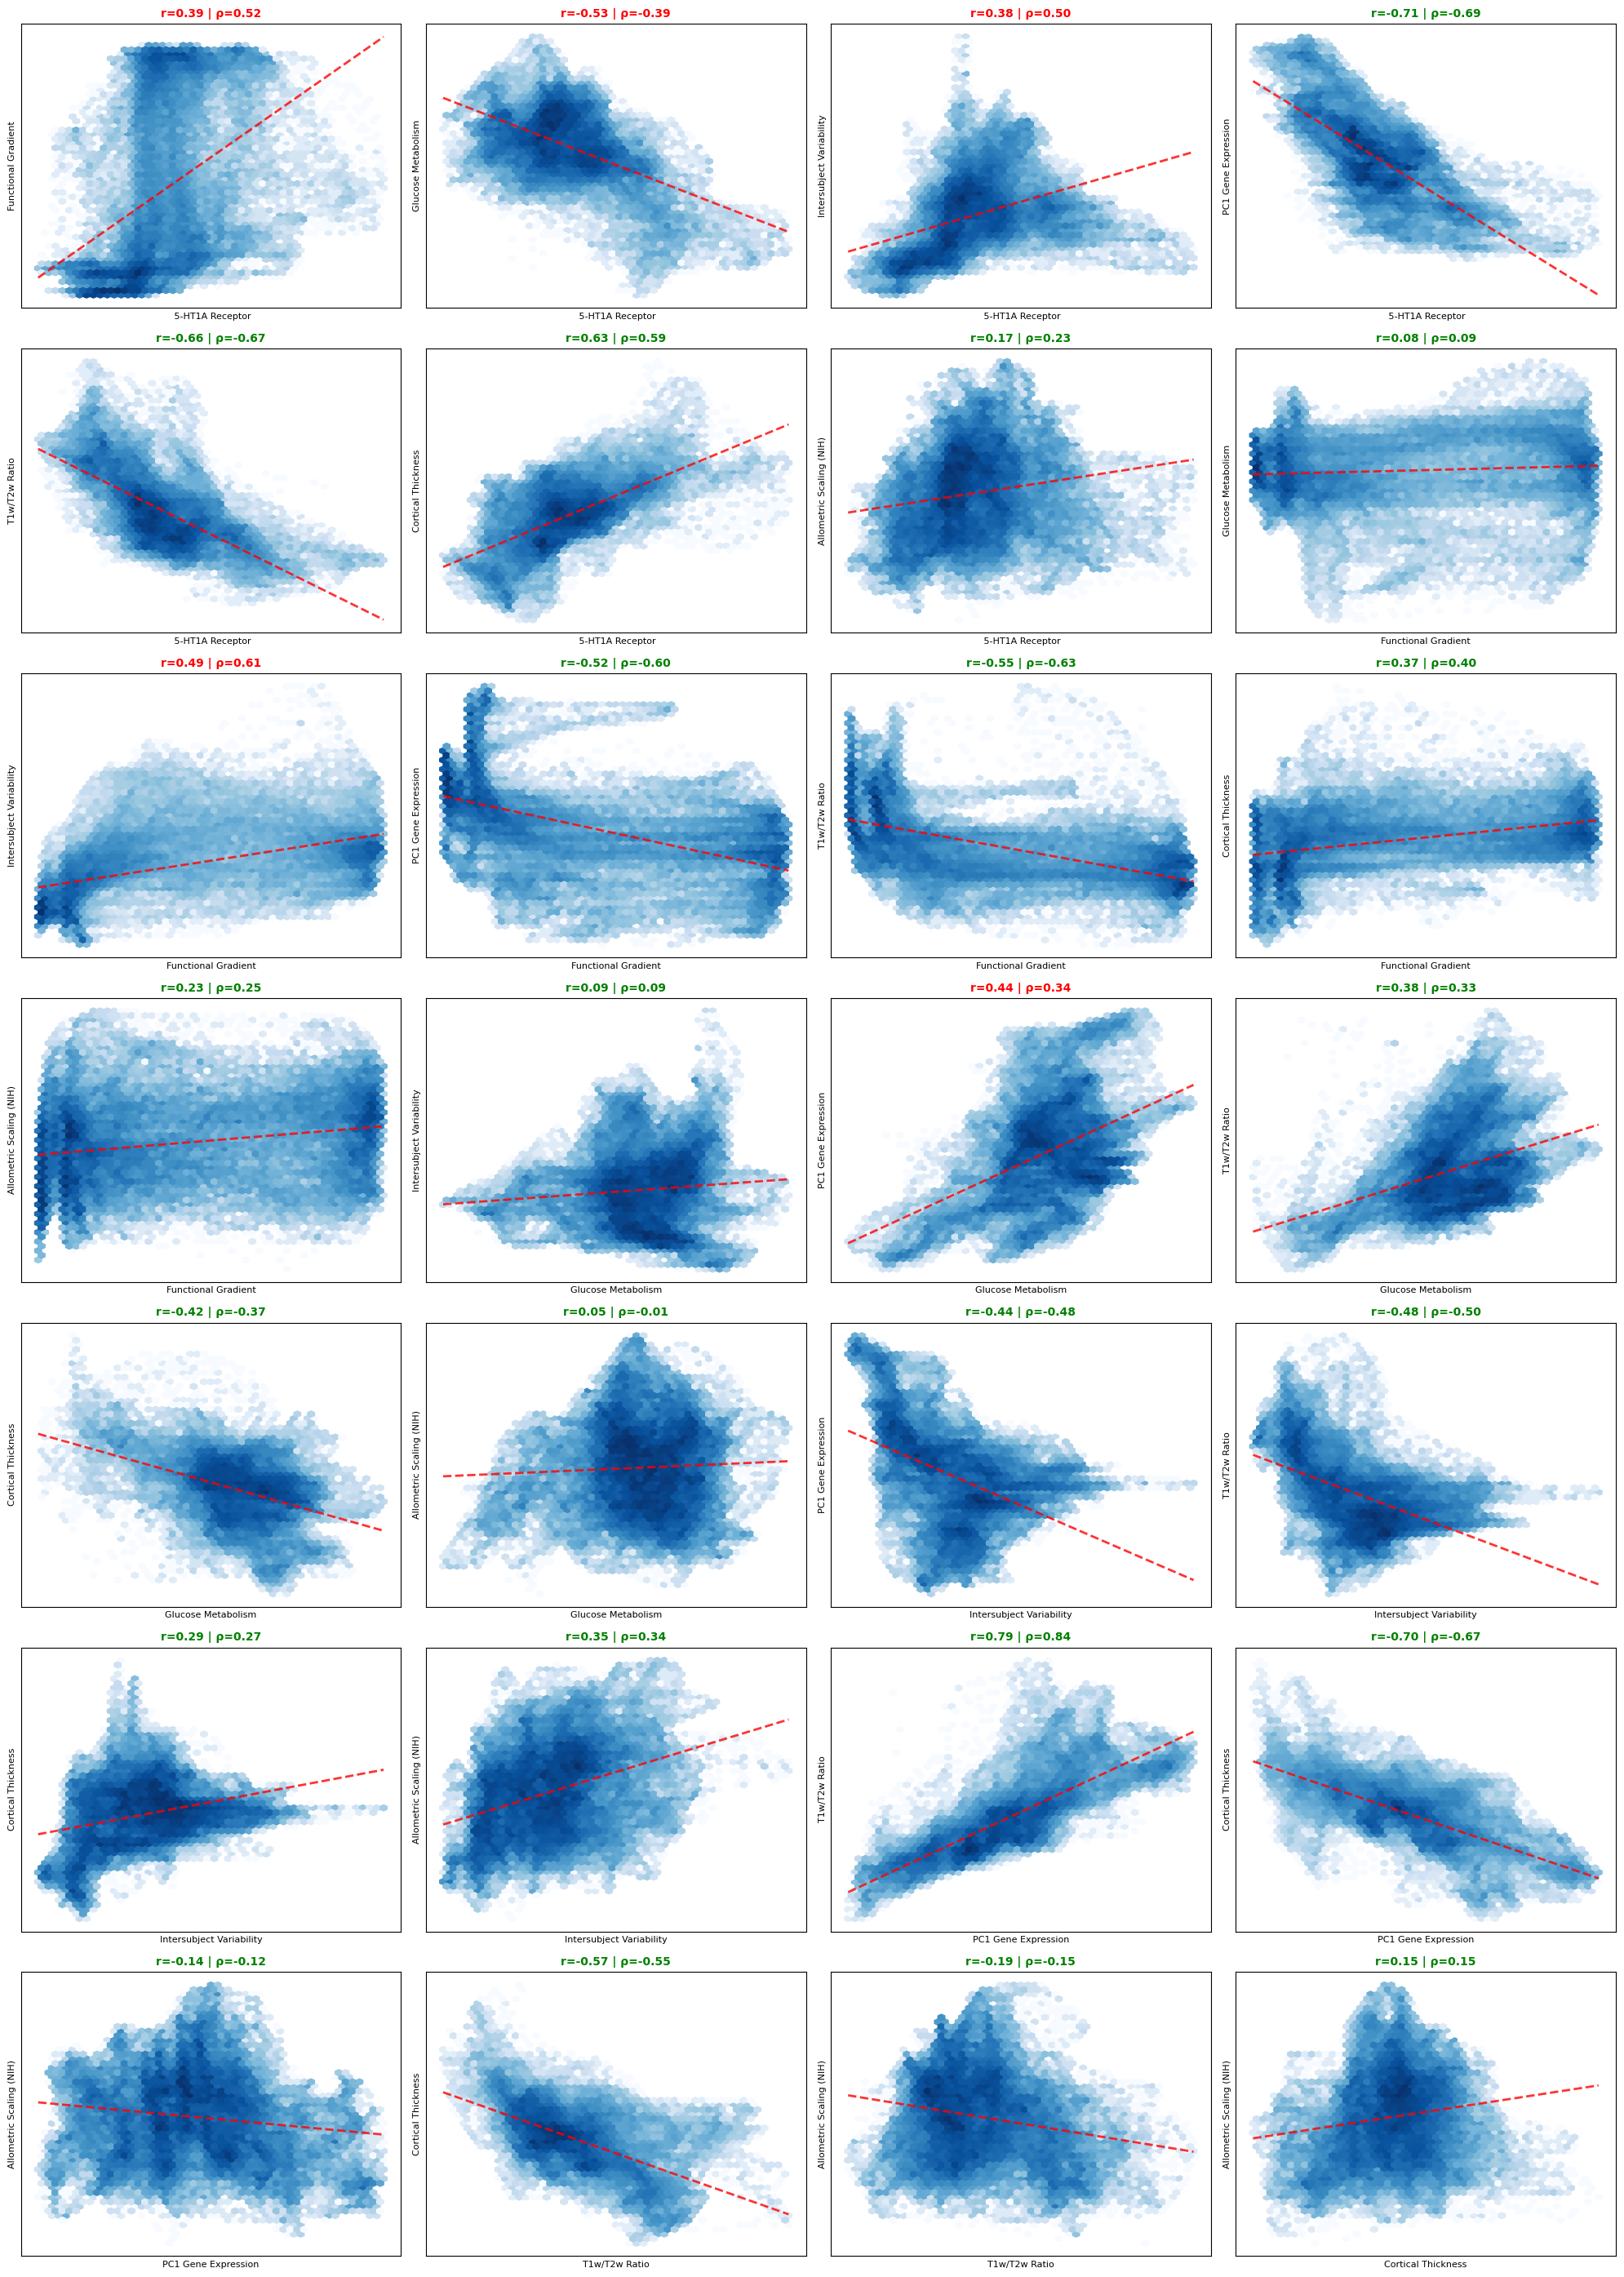

In [34]:
## Run this cell to plot the density scatter plots
raw_density_scatterplot = plot_pairwise_scatterplots(
    prepared_maps, 
    map_names, 
    readable_map_names=readable_map_names
)
raw_density_scatterplot

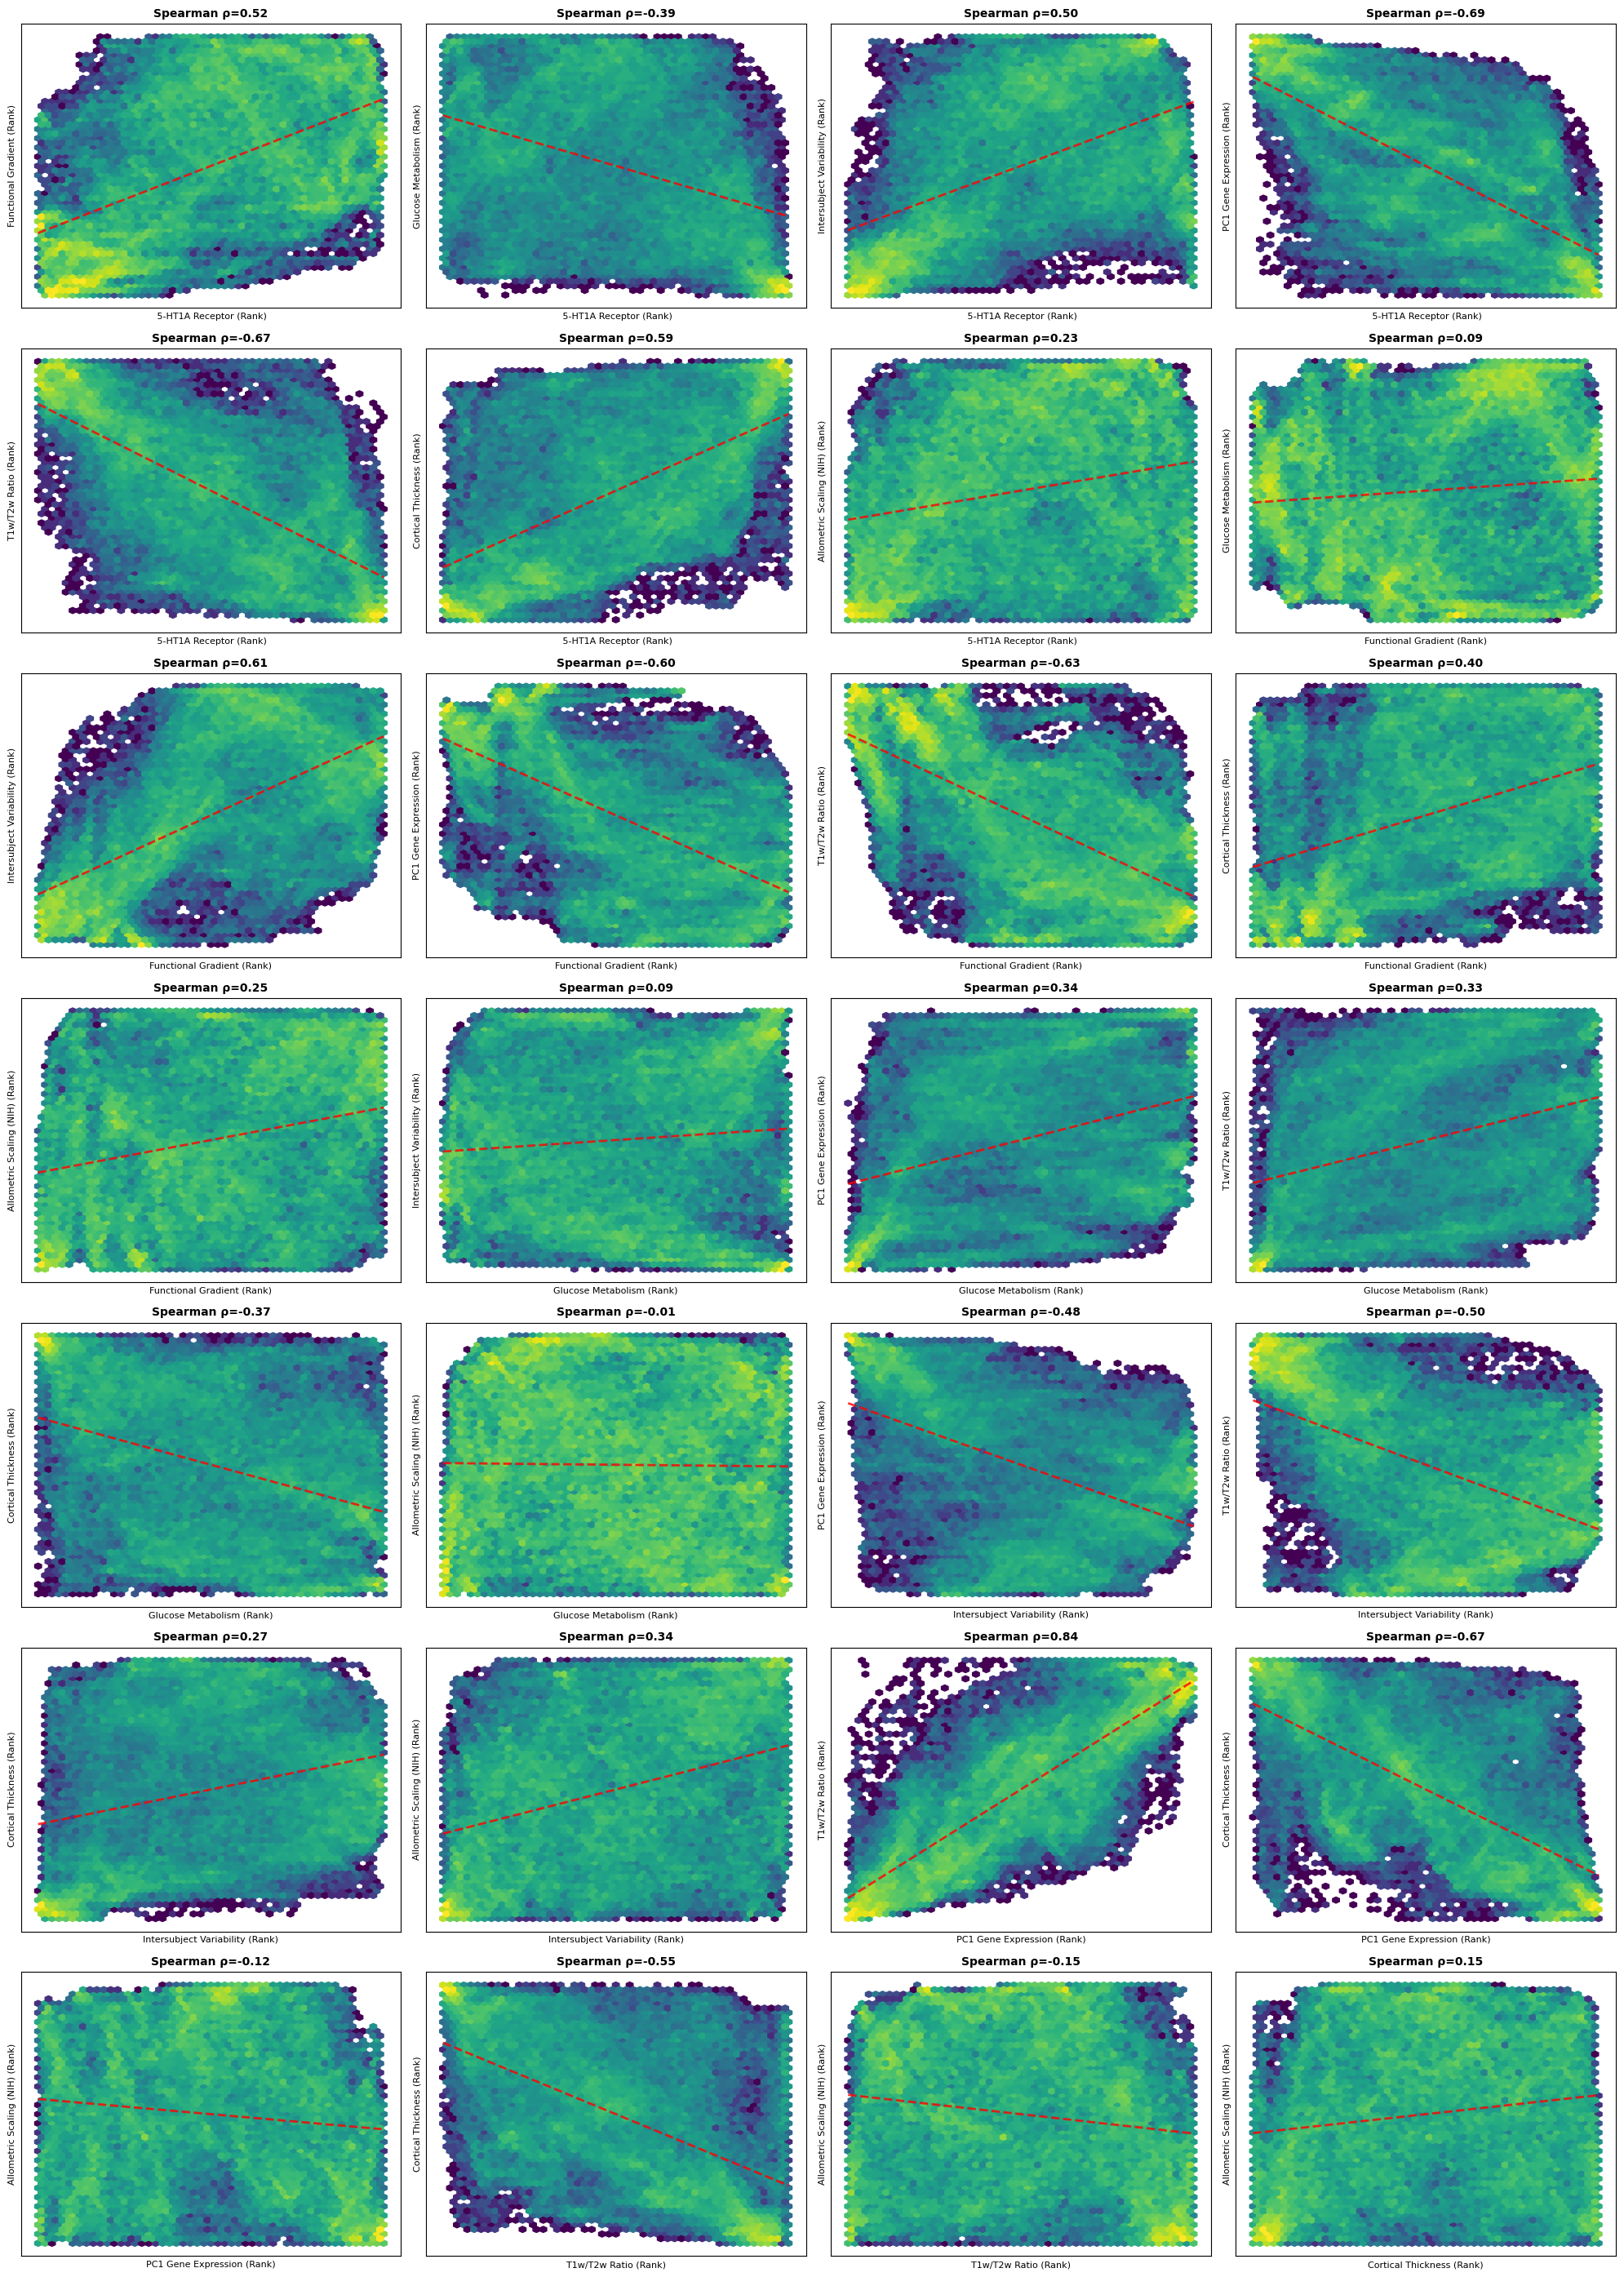

In [35]:
ranked_den_scatterplot = pairwise_rank_scatterplot(
    prepared_maps, 
    map_names, 
    readable_map_names=readable_map_names
)
ranked_den_scatterplot

### Significance Testing

In [12]:
# Mutltiple Tests correction table
def generate_standard_comparison_table(df_corr, df_pvals, alpha=0.05):
    """
    Computes Bonferroni and FDR BH and FDR BY corrections
    """
    
    mask_tri = np.tril(np.ones(df_pvals.shape), k=-1).astype(bool)
    rows, cols = np.where(mask_tri)
    
    map1_names = df_corr.index[rows]
    map2_names = df_corr.columns[cols]
    
    r_values = df_corr.values[mask_tri]
    p_values_uncorrected = df_pvals.values[mask_tri]
    
    # can use p-val for appendix additional tables
    reject_bonf, pvals_bonf, _, _ = multipletests(p_values_uncorrected, alpha=alpha, method='bonferroni')
    reject_fdr_bh, pvals_fdr_bh, _, _ = multipletests(p_values_uncorrected, alpha=alpha, method='fdr_bh')
    reject_fdr_by, pvals_fdr_by, _, _ = multipletests(p_values_uncorrected, alpha=alpha, method='fdr_by')
    
    results = pd.DataFrame({
        'Map 1': map1_names,
        'Map 2': map2_names,
        'Spearman': r_values,
        'P-val (Uncorrected)': p_values_uncorrected,
        'Significant (Uncorrected)': p_values_uncorrected < alpha,
        'Significant (Bonf)': reject_bonf,
        'Significant (FDR-BH)': reject_fdr_bh,
        'Significant (FDR-BY)': reject_fdr_by
    })
    
    float_cols = ['Spearman', 'P-val (Uncorrected)']
    results[float_cols] = results[float_cols].round(4)
    
    return results

# Helper function to compute Max T threshold
def compute_maxt_threshold(prepared_maps, nulls_list, n_perm=1000, method='pearson'):
    data_stack = np.column_stack(prepared_maps)
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    
    max_null_stats = []

    for k in range(n_perm):        
        null_data_k = np.zeros((n_vertices_clean, len(prepared_maps)))
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            if method == 'spearman':
                spin_k = rankdata(spin_k, method='average')
            
            with np.errstate(divide='ignore', invalid='ignore'):
                z_spin = zscore(spin_k, nan_policy='omit')
            null_data_k[:, m] = z_spin

        null_data_k = np.nan_to_num(null_data_k)
        null_corr_matrix = (null_data_k.T @ null_data_k) / n_vertices_clean 
        np.fill_diagonal(null_corr_matrix, 0)
        
        max_r = np.nanmax(np.abs(null_corr_matrix))
        max_null_stats.append(max_r)
        
    threshold = np.nanpercentile(max_null_stats, 95)
    print(f"Max-T Critical Threshold: r > {threshold:.3f}")
    return threshold


# --- Main function for Max T table ---
def compute_and_display_maxt(df_corr, prepared_maps, nulls_list, method='pearson'):
    
    n_perm_actual = nulls_list[0].shape[1]
    
    # compute Threshold
    threshold = compute_maxt_threshold(prepared_maps, nulls_list, n_perm=n_perm_actual, method=method)
    
    if np.isnan(threshold):
        print("Error: Threshold is NaN.")
        return None, None

    mask_tri = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)
    rows, cols = np.where(mask_tri)
    
    map1_names = df_corr.index[rows]
    map2_names = df_corr.columns[cols]
    r_values = df_corr.values[rows, cols]
    
    maxt_table = pd.DataFrame({
        'Map 1': map1_names,
        'Map 2': map2_names,
        'Correlation': r_values,
        'Significant': np.abs(r_values) > threshold  # Logic check applied to all
    }).round(3)
    
    maxt_table = maxt_table.sort_values(by='Correlation', key=abs, ascending=False).reset_index(drop=True)
    
    print("\nFull Max-T Results (All Pairs):")
    display(maxt_table)
    
    plt.figure(figsize=(10, 8))
    df_plot = df_corr.copy()
    visual_mask = np.abs(df_plot) <= threshold
    np.fill_diagonal(visual_mask.values, False)
    
    sns.heatmap(
        df_plot, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        mask=visual_mask,
        cbar_kws={'label': f'{method.capitalize()} Correlation'}
    )
    plt.title(f"Significant Couplings (Max-T Corrected)\nThreshold: |rho| > {threshold:.3f}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return maxt_table, threshold

In [13]:
# Standard table
standard_table = generate_standard_comparison_table(df_corr_spearman, df_pvals_spearman)
print("\n--- Standard Multiple Comparisons Correction Table (Spearman)---")
display(standard_table)


--- Standard Multiple Comparisons Correction Table (Spearman)---


Map 1                     Map 2  Spearman  \
0        Functional Gradient           5-HT1A Receptor     0.519   
1         Glucose Metabolism           5-HT1A Receptor    -0.391   
2         Glucose Metabolism       Functional Gradient     0.092   
3   Intersubject Variability           5-HT1A Receptor     0.497   
4   Intersubject Variability       Functional Gradient     0.612   
5   Intersubject Variability        Glucose Metabolism     0.089   
6        PC1 Gene Expression           5-HT1A Receptor    -0.690   
7        PC1 Gene Expression       Functional Gradient    -0.595   
8        PC1 Gene Expression        Glucose Metabolism     0.340   
9        PC1 Gene Expression  Intersubject Variability    -0.477   
10             T1w/T2w Ratio           5-HT1A Receptor    -0.671   
11             T1w/T2w Ratio       Functional Gradient    -0.629   
12             T1w/T2w Ratio        Glucose Metabolism     0.333   
13             T1w/T2w Ratio  Intersubject Variability    -0.499   
14             T1w/T2w Ratio       PC1 Gene Expression     0.842   
15        Cortical Thickness           5-HT1A Receptor     0.595   
16        Cortical Thickness       Functional Gradient     0.399   
17        Cortical Thickness        Glucose Metabolism    -0.366   
18        Cortical Thickness  Intersubject Variability     0.269   
19        Cortical Thickness       PC1 Gene Expression    -0.665   
20        Cortical Thickness             T1w/T2w Ratio    -0.553   
21  Allometric Scaling (NIH)           5-HT1A Receptor     0.225   
22  Allometric Scaling (NIH)       Functional Gradient     0.252   
23  Allometric Scaling (NIH)        Glucose Metabolism    -0.013   
24  Allometric Scaling (NIH)  Intersubject Variability     0.342   
25  Allometric Scaling (NIH)       PC1 Gene Expression    -0.117   
26  Allometric Scaling (NIH)             T1w/T2w Ratio    -0.150   
27  Allometric Scaling (NIH)        Cortical Thickness     0.147   

    P-val (Uncorrected)  Significant (Uncorrected)  Significant (Bonf)  \
0                 0.002                       True               False   
1                 0.042                       True               False   
2                 0.604                      False               False   
3                 0.003                       True               False   
4                 0.001                       True                True   
5                 0.689                      False               False   
6                 0.001                       True                True   
7                 0.001                       True                True   
8                 0.001                       True                True   
9                 0.001                       True                True   
10                0.001                       True                True   
11                0.001                       True                True   
12                0.131                      False               False   
13                0.005                       True               False   
14                0.001                       True                True   
15                0.001                       True                True   
16                0.009                       True               False   
17                0.070                      False               False   
18                0.154                      False               False   
19                0.001                       True                True   
20                0.001                       True                True   
21                0.152                      False               False   
22                0.109                      False               False   
23                0.944                      False               False   
24                0.020                       True               False   
25                0.001                       True                True   
26                0.449                      False  

Max-T Critical Threshold: r > 0.744

Full Max-T Results (All Pairs):


Map 1                       Map 2  Correlation  \
0           hcps1200_myelinmap              abagen_genepc1        0.716   
1           hcps1200_thickness         savli2012_way100635        0.689   
2     mueller2013_intersubjvar         savli2012_way100635        0.605   
3               abagen_genepc1         savli2012_way100635       -0.590   
4               abagen_genepc1  margulies2016_fcgradient01       -0.586   
5           hcps1200_thickness              abagen_genepc1       -0.577   
6           hcps1200_myelinmap  margulies2016_fcgradient01       -0.575   
7       reardon2018_scalingnih    mueller2013_intersubjvar        0.502   
8           hcps1200_myelinmap              raichle_cmrglc        0.489   
9     mueller2013_intersubjvar  margulies2016_fcgradient01        0.478   
10          hcps1200_thickness    mueller2013_intersubjvar        0.441   
11              abagen_genepc1    mueller2013_intersubjvar       -0.426   
12      reardon2018_scalingnih         savli2012_way100635        0.397   
13  margulies2016_fcgradient01         savli2012_way100635        0.394   
14      reardon2018_scalingnih          hcps1200_thickness        0.349   
15    mueller2013_intersubjvar              raichle_cmrglc        0.314   
16          hcps1200_thickness  margulies2016_fcgradient01        0.295   
17              abagen_genepc1              raichle_cmrglc        0.274   
18          hcps1200_myelinmap         savli2012_way100635       -0.272   
19      reardon2018_scalingnih              raichle_cmrglc        0.246   
20          hcps1200_thickness          hcps1200_myelinmap       -0.177   
21      reardon2018_scalingnih  margulies2016_fcgradient01        0.169   
22          hcps1200_myelinmap    mueller2013_intersubjvar       -0.137   
23      reardon2018_scalingnih          hcps1200_myelinmap        0.126   
24      reardon2018_scalingnih              abagen_genepc1       -0.100   
25              raichle_cmrglc         savli2012_way100635       -0.066   
26              raichle_cmrglc  margulies2016_fcgradient01        0.047   
27          hcps1200_thickness              raichle_cmrglc       -0.036   

    Significant  
0         False  
1         False  
2         False  
3         False  
4         False  
5         False  
6         False  
7         False  
8         False  
9         False  
10        False  
11        False  
12        False  
13        False  
14        False  
15        False  
16        False  
17        False  
18        False  
19        False  
20        False  
21        False  
22        False  
23        False  
24        False  
25        False  
26        False  
27        False

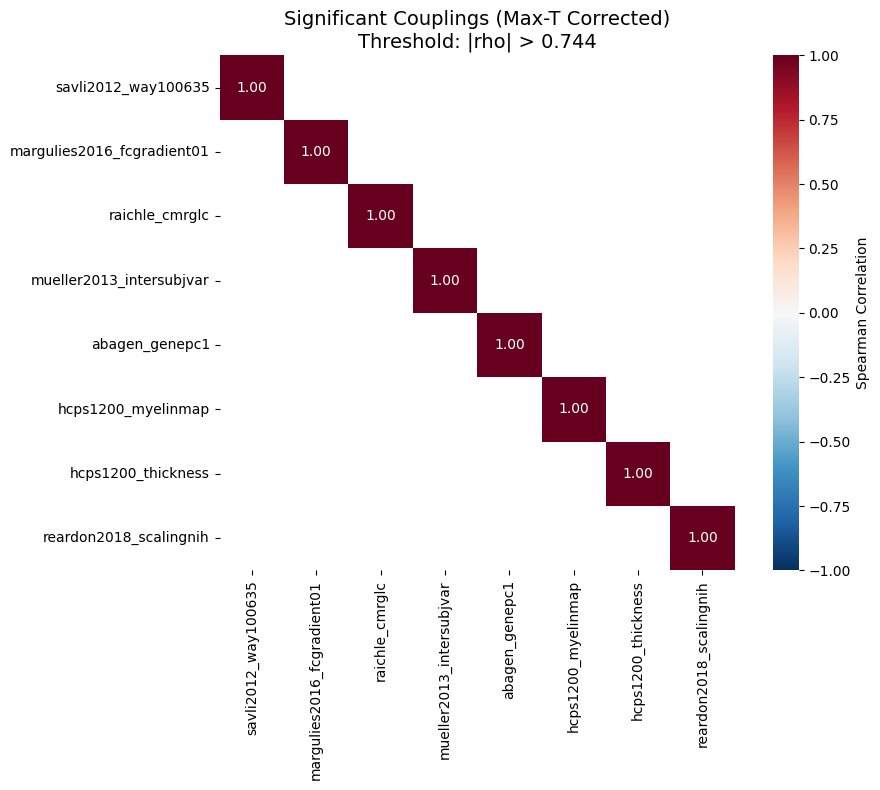

In [36]:
# Run Max-T and get the specific table/plot
maxt_table, threshold = compute_and_display_maxt(
    df_corr_spearman, 
    prepared_maps, 
    nulls_list, 
    method='spearman'
)

### Coupling Brain Maps EDA

In [15]:
# Helper function
def get_readable_title(raw_name, name_dict):
    """Converts technical map name to readable title."""
    for key, readable in name_dict.items():
        if key in raw_name:
            return readable
    return raw_name

# Helper function
def generate_coupling_map(map1_data, map2_data, positive=True):
    """
    Generates a "Local Coupling Map"
    """
    mask = (~np.isnan(map1_data)) & (~np.isnan(map2_data)) & (map1_data != 0) & (map2_data != 0)
    coupling_map = np.zeros_like(map1_data, dtype=float)
    
    d1 = map1_data[mask]
    d2 = map2_data[mask]
    # Rank 0 to 1
    r1 = rankdata(d1, method='average') / len(d1)
    # check for negative relationship
    if positive:
        r2 = rankdata(d2, method='average') / len(d2)
    else:
        r2 = 1.0 - (rankdata(d2, method='average') / len(d2))

    diff = np.abs(r1 - r2)
    coupling_score = 1.0 - diff
    # cubed to account for noise
    coupling_score = coupling_score ** 3
    coupling_map[mask] = coupling_score
    return coupling_map

def plot_coupling_map(coupling_map_data, space='fsLR', den='32k', title='Local Coupling Strength', cmap='magma'):
    """
    Plots the coupling map using neuromaps plotting utilities.
    """
    atlas = fetch_atlas(space, den)
    surf_l = atlas['inflated'].L
    surf_r = atlas['inflated'].R
    n_vertices = len(coupling_map_data)
    mid_point = n_vertices // 2
    data_l = coupling_map_data[:mid_point]
    data_r = coupling_map_data[mid_point:]

    fig = plt.figure(figsize=(10, 4))
    vmin, vmax = 0, 1
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    plotting.plot_surf(
        surf_mesh=surf_l,
        surf_map=data_l,
        hemi='left',
        view='lateral',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        colorbar=False,
        axes=ax1,
        title='Left Hemisphere'
    )
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    plotting.plot_surf(
        surf_mesh=surf_r,
        surf_map=data_r,
        hemi='right',
        view='lateral',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        colorbar=False,
        axes=ax2,
        title='Right Hemisphere'
    )
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin, vmax)
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
    cbar.set_label('Coupling Strength', fontsize=11)
    
    plt.suptitle(title, fontsize=14, y=0.95)
    plt.show()


# Main function for plotting Coupling Brain Map
def plot_all_unique_pairs(map_names, prepared_maps, name_dict):
    """
    Iterates through all unique pairs of maps, calculates Spearman Rho,
    determines direction (pos/neg), generates coupling map, and plots it.
    """
    unique_pairs = list(combinations(range(len(map_names)), 2))

    for i, (idx_a, idx_b) in enumerate(unique_pairs):
        name_a_raw = map_names[idx_a]
        name_b_raw = map_names[idx_b]
        data_a = prepared_maps[idx_a]
        data_b = prepared_maps[idx_b]
        
        # Calculate Spearman correlation for title & direction
        mask = (~np.isnan(data_a)) & (~np.isnan(data_b)) & (data_a != 0) & (data_b != 0)
        rho, _ = spearmanr(data_a[mask], data_b[mask])
        
        # If correlation is notably negative, flip the ranking logic
        # Threshold of -0.1 ensures weak negatives are treated as inverse
        is_positive = rho >= -0.1 
        
        # Generate the Coupling Map
        coupling_brain = generate_coupling_map(data_a, data_b, positive=is_positive)
        
        # Create Title
        title_a = get_readable_title(name_a_raw, name_dict)
        title_b = get_readable_title(name_b_raw, name_dict)
        
        full_title = f"{title_a} vs {title_b} (ρ={rho:.2f})"
    
        plot_coupling_map(coupling_brain, title=full_title)

In [ ]:
plot_all_unique_pairs(map_names, prepared_maps, readable_map_names)

## Kevin H Function

## Principal Component Analysis (PCA)

**Goal:** Reduce the 8×8 Spearman correlation matrix into a small set of orthogonal latent axes (principal components) that capture maximal shared variance across brain maps.

### Inputs
- `df_corr_spearman`: pandas DataFrame containing the Spearman correlation matrix $R \in \mathbb{R}^{8\times 8}$ across the 8 brain maps.
- `names`: list of brain map names aligned to the rows/columns of `df_corr_spearman`.

### Steps implemented in code

1. **Eigendecomposition of the correlation matrix**
   - Because \(R\) is symmetric, the code uses `np.linalg.eigh`, which is numerically stable and tailored to symmetric matrices.
   - `eigh` returns eigenvalues in **ascending** order.

   **Code behavior:**
   - `eigvals, eigvecs = np.linalg.eigh(df_corr_spearman.values)`

2. **Sort eigenvalues/eigenvectors in descending order**
   - PCA convention labels PC1 as the component with the largest eigenvalue.
   - The code sorts eigenvalues in descending order and reorders eigenvectors accordingly.

   **Code behavior:**
   - `idx = np.argsort(eigvals)[::-1]`
   - `eigvals = eigvals[idx]`
   - `eigvecs = eigvecs[:, idx]`

3. **Compute variance explained**
   - The proportion of variance explained by each PC is computed as:
     $$
     \text{var\_exp}_k = \frac{\lambda_k}{\sum_{j=1}^{p}\lambda_j}
     $$
   - Where $\lambda_k$ is the $k$-th eigenvalue.

   **Code behavior:**
   - `var_exp = eigvals / eigvals.sum()`

4. **Compute component loadings**
   - To obtain interpretable contributions of each map to each component, loadings are computed as:
     $$
     L = V\Lambda^{1/2}
     $$
     where \(V\) contains eigenvectors and $\Lambda$ is the diagonal matrix of eigenvalues.
   - This rescales eigenvectors by the square root of the component variance.

   **Code behavior:**
   - `loadings = eigvecs * np.sqrt(eigvals)`
   - Broadcasting multiplies each column $k$ of `eigvecs` by $\sqrt{\lambda_k}$.

5. **PC1 vs PC2 loading scatter plot**
   - The code extracts the first two loading columns for a 2D scatter:
     - `x = loadings[:, 0]` (PC1 loadings)
     - `y = loadings[:, 1]` (PC2 loadings)
   - Points are labeled with the corresponding brain map name from `names`.
   - Axes include the variance explained for PC1/PC2 via `var_exp`.

   **Code behavior:**
   - Draw axes at 0 (horizontal and vertical reference lines)
   - Scatter plot `x` vs `y`
   - Label each point with the map name
   - Axis labels: `PC1 loading (var=...)`, `PC2 loading (var=...)`

### Outputs
- `eigvals`: eigenvalues (sorted descending)
- `eigvecs`: eigenvectors aligned to sorted eigenvalues
- `var_exp`: variance explained per PC
- `loadings`: map-by-PC matrix of PCA loadings
- Figure: PC1 vs PC2 loading scatter (with labels)

In [37]:
df_corr_spearman

savli2012_way100635  margulies2016_fcgradient01  \
savli2012_way100635                       1.000                       0.394   
margulies2016_fcgradient01                0.394                       1.000   
raichle_cmrglc                           -0.066                       0.047   
mueller2013_intersubjvar                  0.605                       0.478   
abagen_genepc1                           -0.590                      -0.586   
hcps1200_myelinmap                       -0.272                      -0.575   
hcps1200_thickness                        0.689                       0.295   
reardon2018_scalingnih                    0.397                       0.169   

                            raichle_cmrglc  mueller2013_intersubjvar  \
savli2012_way100635                 -0.066                     0.605   
margulies2016_fcgradient01           0.047                     0.478   
raichle_cmrglc                       1.000                     0.314   
mueller2013_intersubjvar             0.314                     1.000   
abagen_genepc1                       0.274                    -0.426   
hcps1200_myelinmap                   0.489                    -0.137   
hcps1200_thickness                  -0.036                     0.441   
reardon2018_scalingnih               0.246                     0.502   

                            abagen_genepc1  hcps1200_myelinmap  \
savli2012_way100635                 -0.590              -0.272   
margulies2016_fcgradient01          -0.586              -0.575   
raichle_cmrglc                       0.274               0.489   
mueller2013_intersubjvar            -0.426              -0.137   
abagen_genepc1                       1.000               0.716   
hcps1200_myelinmap                   0.716               1.000   
hcps1200_thickness                  -0.577              -0.177   
reardon2018_scalingnih              -0.100               0.126   

                            hcps1200_thickness  reardon2018_scalingnih  
savli2012_way100635                      0.689                   0.397  
margulies2016_fcgradient01               0.295                   0.169  
raichle_cmrglc                          -0.036                   0.246  
mueller2013_intersubjvar                 0.441                   0.502  
abagen_genepc1                          -0.577                  -0.100  
hcps1200_myelinmap                      -0.177                   0.126  
hcps1200_thickness                       1.000                   0.349  
reardon2018_scalingnih                   0.349                   1.000

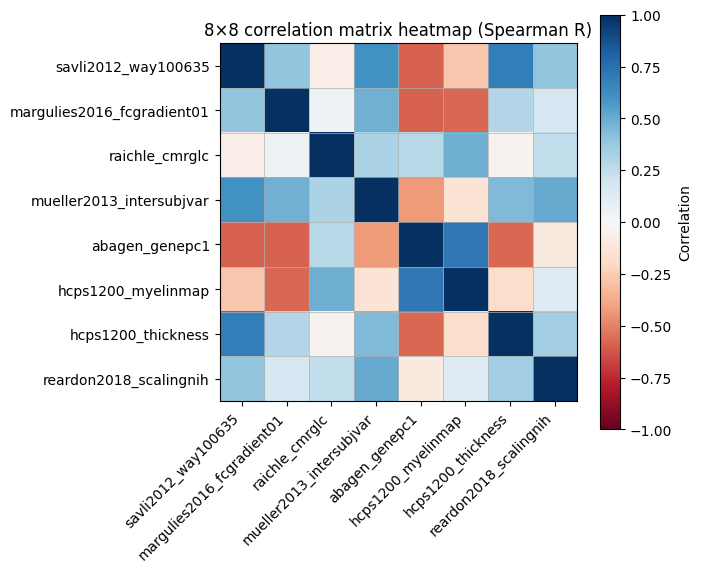

In [48]:
def plot_correlation_heatmap(corr_matrix, labels, title="Correlation Matrix Heatmap", figsize=(7, 6), cmap='RdBu'):
    """
    Plots a heatmap for a given correlation matrix.

    Parameters:
        corr_matrix (2D array-like): Correlation matrix to visualize.
        labels (list): Labels for the x and y axes.
        title (str): Title of the heatmap.
        figsize (tuple): Size of the figure.
        cmap (str): Colormap for the heatmap.
    """
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr_matrix, vmin=-1, vmax=1, cmap=cmap)  # correlation range

    # ticks + labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    # grid lines to separate cells
    ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Correlation")

    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(df_corr_spearman, map_names, title="8×8 correlation matrix heatmap (Spearman R)")

In [54]:
def plot_pca_and_scree(corr_matrix, labels, figsize_scatter=(6, 6), figsize_scree=(6, 4)):
    """
    Performs PCA on a correlation matrix and plots the loadings scatter plot and scree plot.

    Parameters:
        corr_matrix (DataFrame or 2D array-like): Correlation matrix for PCA.
        labels (list): Labels for the scatter plot points.
        figsize_scatter (tuple): Size of the scatter plot figure.
        figsize_scree (tuple): Size of the scree plot figure.
    """
    # Perform PCA
    eigvals, eigvecs = np.linalg.eigh(corr_matrix.values)  # ascending
    idx = np.argsort(eigvals)[::-1]  # sort descending
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Variance explained
    var_exp = eigvals / eigvals.sum()
    
    # Calculate Loadings
    loadings = eigvecs * np.sqrt(eigvals)
    
    # Coordinates for PC1/PC2 plot
    x = loadings[:, 0]
    y = loadings[:, 1]
    
    # Plot: loadings scatter with labels
    plt.figure(figsize=figsize_scatter)
    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)
    plt.scatter(x, y)
    for i, name in enumerate(labels):
        plt.text(x[i], y[i], "  " + name, va="center")
    plt.xlabel(f"PC1 loading (var={var_exp[0]:.2%})")
    plt.ylabel(f"PC2 loading (var={var_exp[1]:.2%})")
    plt.title("PCA of Correlation Matrix (Loadings)")
    plt.tight_layout()
    plt.show()
    
    # Plot: Scree plot
    plt.figure(figsize=figsize_scree)
    plt.plot(np.arange(1, len(var_exp) + 1), var_exp, marker="o")
    plt.xticks(np.arange(1, len(var_exp) + 1))
    plt.xlabel("Principal component")
    plt.ylabel("Proportion variance explained")
    plt.title("Scree Plot (from Correlation Matrix)")
    plt.tight_layout()
    plt.show()
    return loadings, var_exp

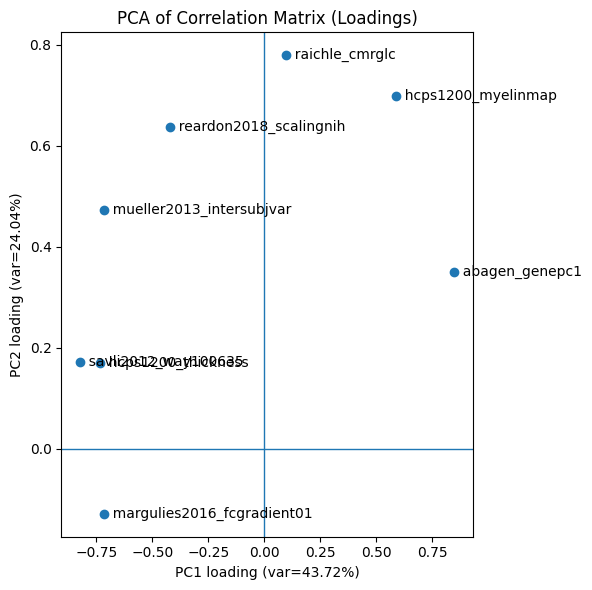

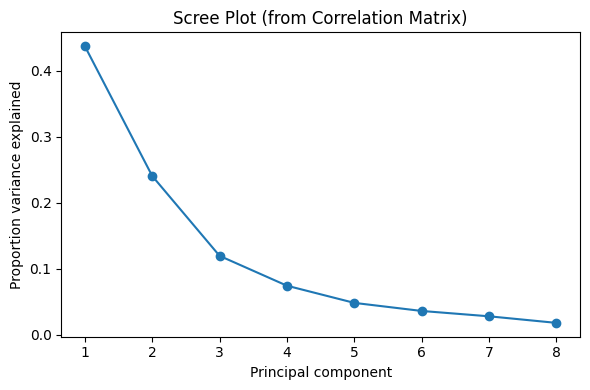

array([[-0.82348464,  0.17136994,  0.30872286, -0.10391965,  0.23348365,
         0.2541154 ,  0.25890781,  0.01654649],
       [-0.71511305, -0.12831464, -0.57032115,  0.04240882, -0.18761433,
         0.30906074, -0.10070699, -0.06499522],
       [ 0.09557241,  0.77938261, -0.46379625, -0.30765816, -0.13146993,
        -0.11950336,  0.19439059,  0.06568902],
       [-0.71607843,  0.47354017, -0.20649449,  0.01457254,  0.38823186,
        -0.12884624, -0.22778197,  0.03048124],
       [ 0.85006316,  0.35064824,  0.00653878,  0.11616606,  0.05566493,
         0.26601478, -0.09502941,  0.24084871],
       [ 0.58688957,  0.69823745,  0.22534936, -0.15687267,  0.00700477,
         0.14204608, -0.10770787, -0.24658991],
       [-0.73621232,  0.17058135,  0.44956457, -0.30894182, -0.29670374,
        -0.0193299 , -0.17404268,  0.11243873],
       [-0.42106924,  0.63721556,  0.15198043,  0.59263112, -0.18716025,
        -0.06104715,  0.05851092, -0.01296453]])

In [55]:
loadings, var_exp = plot_pca_and_scree(df_corr_spearman, map_names)
loadings

In [56]:
def plot_pca_loadings_heatmap(loadings, labels, var_exp, figsize=(10, 6), cmap='RdBu'):
    """
    Plots a heatmap of PCA loadings.

    Parameters:
        loadings (2D array-like): PCA loadings matrix (PCs × features).
        labels (list): Labels for the columns (features).
        var_exp (array-like): Variance explained by each principal component.
        figsize (tuple): Size of the heatmap figure.
        cmap (str): Colormap for the heatmap.
    """
    L = loadings.T  # Transpose to (PCs × features)
    plt.figure(figsize=figsize)
    im = plt.imshow(L, aspect="auto", vmin=-1, vmax=1, cmap=cmap, alpha=0.8)
    
    # Axis labels
    plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(np.arange(len(L)), [f"PC{i+1} ({var_exp[i]:.1%})" for i in range(len(L))])
    plt.title("PCA Loadings Heatmap (PCs × Features)")
    
    # Annotate each cell value
    for i in range(len(L)):
        for j in range(len(labels)):
            plt.text(j, i, f"{L[i, j]:.2f}", ha="center", va="center", fontsize=8)
    
    plt.colorbar(im, label="Loading")
    plt.tight_layout()
    plt.show()

In [ ]:
# L = loadings.T  # (8 PCs, 8 maps)
# plt.figure(figsize=(10, 6))
# im = plt.imshow(L, aspect="auto", vmin=-1, vmax=1, cmap='RdBu', alpha=0.8)
# # axis labels
# plt.xticks(np.arange(len(map_names)), map_names, rotation=45, ha="right")
# plt.yticks(np.arange(len(L)), [f"PC{i+1} ({var_exp[i]:.1%})" for i in range(len(L))])
# plt.title("PCA loadings heatmap (PCs × maps)")
# # annotate each cell value
# for i in range(len(L)):
#     for j in range(len(map_names)):
#         plt.text(j, i, f"{L[i, j]:.2f}", ha="center", va="center", fontsize=8)
# plt.colorbar(im, label="Loading")
# plt.tight_layout()
# plt.show()

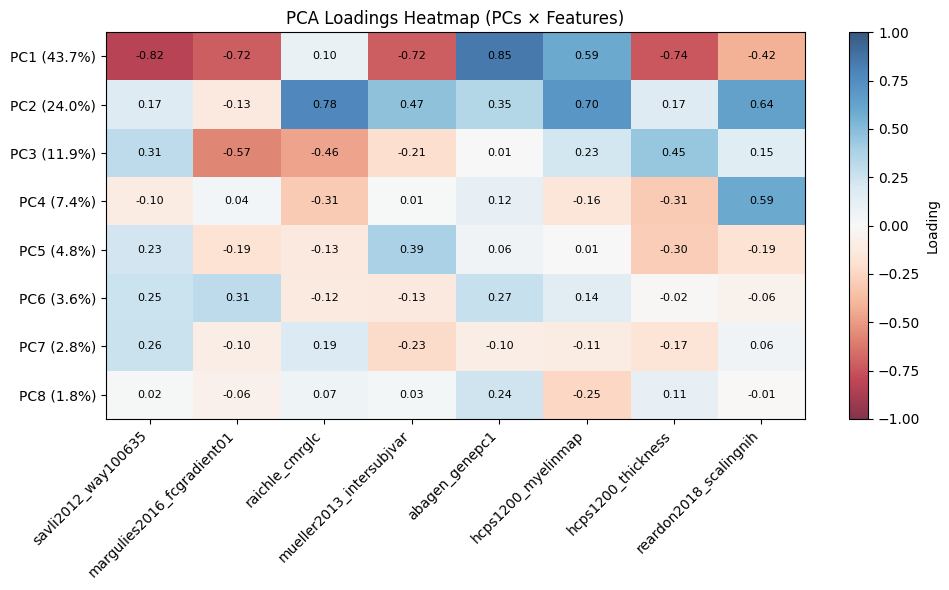

In [57]:
plot_pca_loadings_heatmap(loadings, map_names, var_exp)

## Hierarchical Clustering (Correlation-Derived Distances)

**Goal:** Cluster brain maps based on similarity of their correlation structure to detect whether maps naturally separate into distinct groups.

### Inputs
- `df_corr_spearman`: Spearman correlation matrix \(R\).

### Steps implemented in code

1. **Convert correlation matrix to distance matrix**
   - Correlations are converted into distances using:
     $$
     D = 1 - R
     $$
   - High correlation $\Rightarrow$ small distance.
   - Diagonal is set to 0 to enforce self-distance = 0.

   **Code behavior:**
   - `D = 1 - df_corr_spearman.values`
   - `np.fill_diagonal(D, 0)`

2. **Convert to condensed distance vector**
   - SciPy’s `linkage` expects a condensed distance vector (upper triangle of $D$).
   - `squareform(D, checks=False)` converts the square matrix to condensed format.
   - `checks=False` skips additional validation and is safe when `D` is known symmetric with zeros on the diagonal.

   **Code behavior:**
   - `D_condensed = squareform(D, checks=False)`

3. **Compute linkage matrix**
   - Agglomerative clustering is performed with `average` linkage:
     $$
     d(A,B) = \frac{1}{|A||B|}\sum_{i\in A}\sum_{j\in B} D_{ij}
     $$
   - The algorithm repeatedly merges the two closest clusters until all items are merged into a dendrogram.

   **Code behavior:**
   - `Z = linkage(D_condensed, method="average")`

4. **Plot dendrogram**
   - The dendrogram visualizes the hierarchy of merges and the distances at which merges occur.
   - Labels correspond to the brain map names (`corr_df.index.tolist()`).

   **Code behavior:**
   - `dendrogram(Z, labels=corr_df.index.tolist(), leaf_rotation=45)`

5. **Extract flat clusters**
   - The dendrogram is cut into `n_clusters = 2` clusters using:
     - `criterion="maxclust"`: produce at most `t` clusters.
   - This yields a cluster assignment per map.

   **Code behavior:**
   - `h_labels = fcluster(Z, t=n_clusters, criterion="maxclust")`
   - Cluster labels stored in a DataFrame:
     - `h_cluster_df = pd.DataFrame({"map": corr_df.index, "cluster": h_labels}).set_index("map")`

### Outputs
- `Z`: linkage matrix encoding hierarchical merge structure
- Dendrogram plot
- `h_labels`: cluster assignment for each map
- `h_cluster_df`: map-to-cluster table

In [59]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

def plot_hierarchical_clustering(corr_matrix, labels, method="average", figsize=(12, 8)):
    """
    Performs hierarchical clustering on a correlation matrix and plots the dendrogram.

    Parameters:
        corr_matrix (DataFrame or 2D array-like): Correlation matrix for clustering.
        labels (list): Labels for the dendrogram leaves.
        method (str): Linkage method for clustering (e.g., "average", "complete", "ward").
        figsize (tuple): Size of the dendrogram figure.
    """
    from scipy.cluster.hierarchy import linkage, dendrogram
    from scipy.spatial.distance import squareform

    # Distance matrix from correlation
    D = 1 - corr_matrix.values
    np.fill_diagonal(D, 0)

    # Condensed distance for linkage
    D_condensed = squareform(D, checks=False)

    # Perform hierarchical clustering
    Z = linkage(D_condensed, method=method)

    # Plot dendrogram
    plt.figure(figsize=figsize)
    plt.title("Dendrogram of Hierarchical Clustering")
    dendrogram(Z, labels=labels, leaf_rotation=45)
    plt.tight_layout()
    plt.show()

    return Z

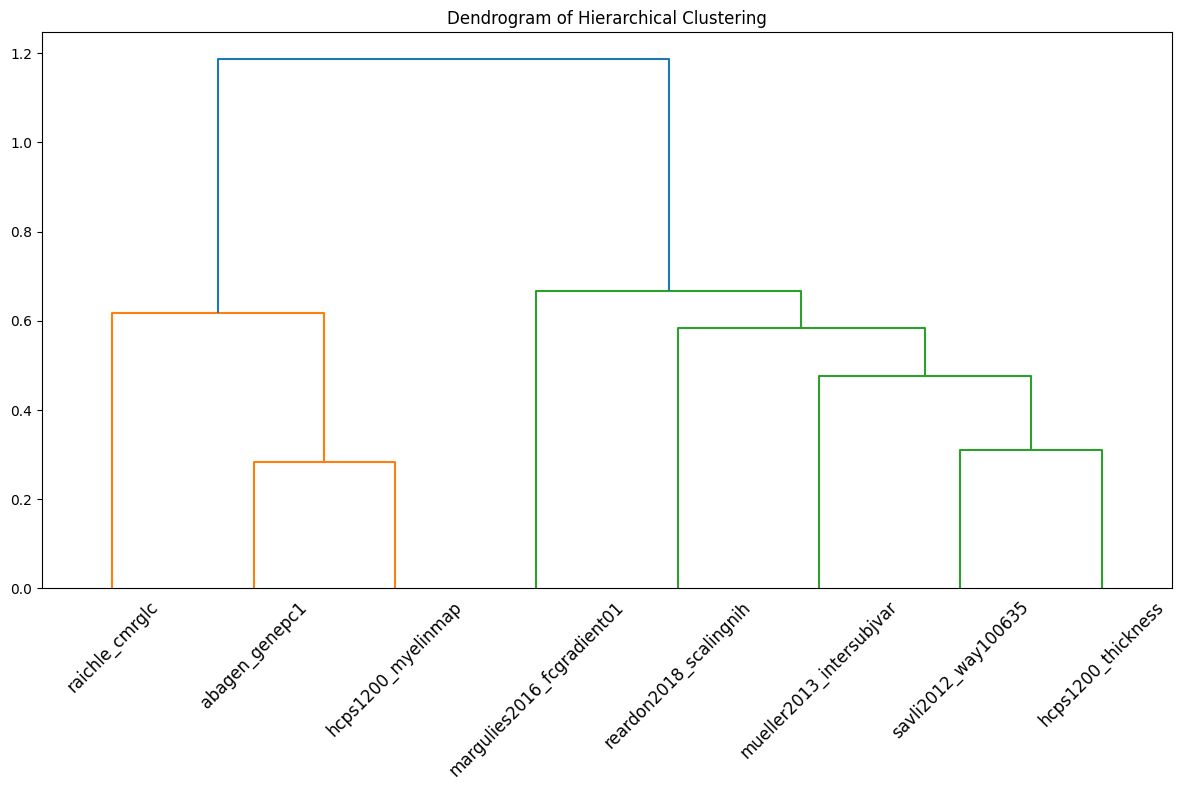

In [60]:
Z = plot_hierarchical_clustering(df_corr_spearman, df_corr_spearman.index.tolist(), method="average")

In [61]:
n_clusters = 2
h_labels = fcluster(Z, t=n_clusters, criterion="maxclust")

h_cluster_df = pd.DataFrame({"map": df_corr_spearman.index, "cluster": h_labels}).set_index("map")
h_cluster_df.sort_values("cluster")

cluster
map                                
raichle_cmrglc                    1
abagen_genepc1                    1
hcps1200_myelinmap                1
savli2012_way100635               2
margulies2016_fcgradient01        2
mueller2013_intersubjvar          2
hcps1200_thickness                2
reardon2018_scalingnih            2

## Subgroup Connectivity Analysis (Within vs Between Clusters)

**Goal:** Quantify whether maps are more strongly correlated *within* clusters than *between* clusters, using mean Spearman correlations.

### Inputs
- `df_corr_spearman`: Spearman correlation matrix \(R\).
- `h_labels`: cluster assignments for each map (aligned to `df_corr_spearman.index`).

### Definitions
Let the two clusters be index sets \(\mathcal{G}_1\) and \(\mathcal{G}_2\).

- **Within-cluster mean correlation** (excluding diagonal):
  $$
  \bar{r}_{\text{within},1} = \text{mean}\{R_{ij} : i\in \mathcal{G}_1, j\in \mathcal{G}_1, i\neq j\}
  $$
  $$
  \bar{r}_{\text{within},2} = \text{mean}\{R_{ij} : i\in \mathcal{G}_2, j\in \mathcal{G}_2, i\neq j\}
  $$

- **Between-cluster mean correlation**:
  $$
  \bar{r}_{\text{between}} = \text{mean}\{R_{ij} : i\in \mathcal{G}_1, j\in \mathcal{G}_2\}
  $$

### Code logic (as implemented conceptually)

1. **Identify indices per cluster**
- Construct index lists (or boolean masks) for the two clusters based on `h_labels`.

2. **Extract within-cluster blocks**
- Extract the submatrices $R_{11}$ and $R_{22}$.
- Remove diagonal entries before averaging so that self-correlations (=1) do not inflate the mean.

3. **Extract between-cluster block**
- Extract cross-block $R_{12}$ and average all entries.

4. **Summarize**
- Report the three mean correlations:
  - within cluster 1
  - within cluster 2
  - between clusters

### Outputs
- `within_mean_1`: mean Spearman correlation within Cluster 1 (off-diagonal)
- `within_mean_2`: mean Spearman correlation within Cluster 2 (off-diagonal)
- `between_mean`: mean Spearman correlation between clusters
- A summary table used in the Results section

In [43]:
def subgroup_connectivity(corr_df, labels, label_index=None):
    """
    corr_df: (n x n) DataFrame
    labels: array-like length n (in same order as corr_df.index unless label_index provided)
    label_index: optional index aligned to corr_df.index
    """
    if label_index is None:
        label_index = corr_df.index

    lab = pd.Series(labels, index=label_index).reindex(corr_df.index)
    C = corr_df.values
    n = C.shape[0]

    within = []
    between = []
    for i in range(n):
        for j in range(i+1, n):
            if lab.iloc[i] == lab.iloc[j]:
                within.append(C[i,j])
            else:
                between.append(C[i,j])

    return {
        "within_mean": float(np.mean(within)) if within else np.nan,
        "between_mean": float(np.mean(between)) if between else np.nan,
        "within_vals": np.array(within),
        "between_vals": np.array(between),
        "labels": lab
    }

# example using hierarchical labels:
res = subgroup_connectivity(df_corr_spearman, h_labels)
res["within_mean"], res["between_mean"]

(0.446, -0.18726666666666666)

In [44]:
res['labels']

savli2012_way100635           2
margulies2016_fcgradient01    2
raichle_cmrglc                1
mueller2013_intersubjvar      2
abagen_genepc1                1
hcps1200_myelinmap            1
hcps1200_thickness            2
reardon2018_scalingnih        2
dtype: int32

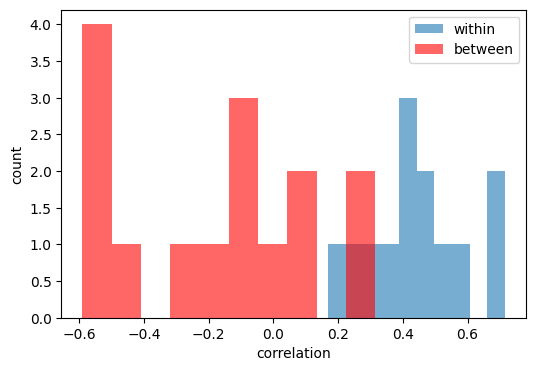

In [45]:
plt.figure(figsize=(6,4))
plt.hist(res["within_vals"], alpha=0.6, label="within")
plt.hist(res["between_vals"], alpha=0.6, label="between", color="r")
plt.legend()
plt.xlabel("correlation")
plt.ylabel("count")
plt.show()

### debuging

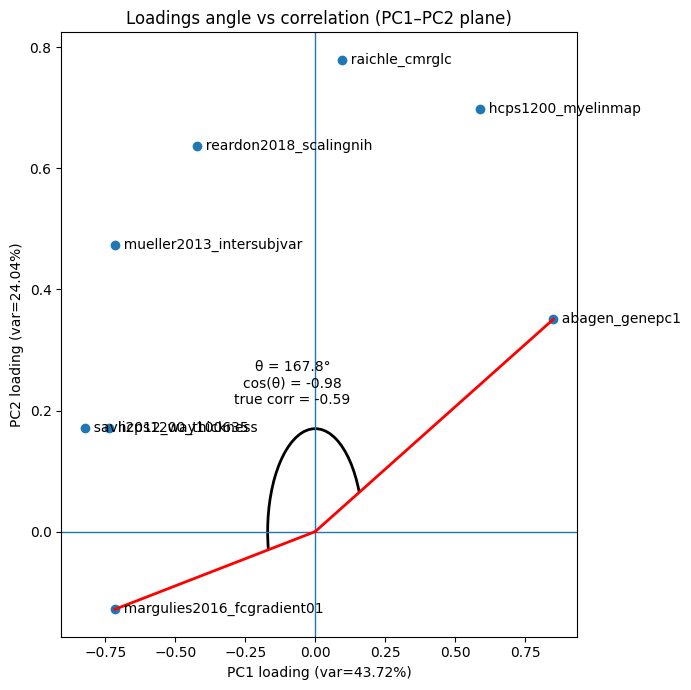

In [62]:
'''
This plot seems buggy

'''
from matplotlib.patches import Arc

# x, y are PC1/PC2 loadings (same order as names)
# names is corr_df_spear.index.to_list()

name_a = "abagen_genepc1"
name_b = "margulies2016_fcgradient01"

i = map_names.index(name_a)
j = map_names.index(name_b)

u = np.array([x[i], y[i]])
v = np.array([x[j], y[j]])

# angle between u and v (0..180 degrees)
cos_theta = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
cos_theta = np.clip(cos_theta, -1, 1)
theta = np.degrees(np.arccos(cos_theta))

# angles of each ray for drawing
ang_u = np.degrees(np.arctan2(u[1], u[0]))
ang_v = np.degrees(np.arctan2(v[1], v[0]))
ang1, ang2 = sorted([ang_u, ang_v])

# handle wrap-around so we draw the smaller arc
if ang2 - ang1 > 180:
    ang1, ang2 = ang2, ang1 + 360

# actual correlation from your matrix
# corr_true = corr_df_spear.loc[name_a, name_b]
corr_true = df_corr_spearman.loc[name_a, name_b]

# plot
plt.figure(figsize=(7, 7))
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

# scatter all points
plt.scatter(x, y)
for k, nm in enumerate(map_names):
    plt.text(x[k], y[k], "  " + nm, va="center")

# highlight chosen pair
#plt.scatter([u[0], v[0]], [u[1], v[1]], s=80)

# draw rays from origin
plt.plot([0, u[0]], [0, u[1]], linewidth=2, color='r')
plt.plot([0, v[0]], [0, v[1]], linewidth=2, color='r')

# draw angle arc
r = 0.2 * max(np.max(np.abs(x)), np.max(np.abs(y)))  # arc radius scaled to plot
arc = Arc((0, 0), 2*r, 2*r, angle=0, theta1=ang1, theta2=ang2, linewidth=2)
plt.gca().add_patch(arc)

# label the angle near the arc midpoint
mid = np.radians((ang1 + ang2) / 2)
plt.text(r*np.cos(mid)*1.7, r*np.sin(mid)*1.5,
         f"θ = {theta:.1f}°\ncos(θ) = {cos_theta:.2f}\ntrue corr = {corr_true:.2f}",
         ha="center", va="center")

plt.xlabel(f"PC1 loading (var={var_exp[0]:.2%})")
plt.ylabel(f"PC2 loading (var={var_exp[1]:.2%})")
plt.title("Loadings angle vs correlation (PC1–PC2 plane)")
plt.tight_layout()
plt.show()


In [ ]:
u, v